Begun 3/13/24

Notebook healpy_only_mask_test_4_20240312 seemed to suggest that the full sky spectra weren't perfectly recovering the CAMB input spectrum, even for the unrotated maps. To test if this is an issue with iterative convergence in anafast, I'm going to rerun that calculation with more iterations than the default (which is 3).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import nawrapper as nw
import yaml
import time
import healpy as hp

In [2]:
# Load CAMB spectra
ell_camb,DlTT_camb,DlEE_camb,DlBB_camb,DlTE_camb = np.loadtxt( \
            "/home/zbh5/act_analysis/act_axion_analysis/resources/camb_19413797_lensedtotcls.dat", \
                                                              usecols=(0,1,2,3,4), unpack=True) 
# Note that ell_camb runs from 2 to 5400
# Healpy expects ell to start at zero
# Initializing new arrays with first two entries set to zero
arr_len = ell_camb.size+2
ell = np.zeros(arr_len)
ell[1] = 1
ell[2:] = ell_camb
ClTT = np.zeros(arr_len)
ClEE = np.zeros(arr_len)
ClTE = np.zeros(arr_len)
ClBB = np.zeros(arr_len)
# convert Dl to Cl
ClTT[2:] = DlTT_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClEE[2:] = DlEE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClTE[2:] = DlTE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClBB[2:] = DlBB_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))

In [5]:
# Functions to calculate likelihood and fit for angle
# These are the only things being tested by these full sky sims at different rotation angles
def estimator_likelihood(angle, estimator, covariance, ClEE):
    """For a given difference in angle between the depth-1 map (map 1) and the coadd (map 2),
       returns the value of the normalized likelihood for our estimator.
       
       ClEE is the theory EE spectrum from CAMB"""

    numerator = (estimator - ClEE*np.sin(2*angle))**2
    denominator = 2*covariance
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def null_eb_estimator_likelihood(angle,eb,ee,bb,ClEE):
    """Returns null EB estimator from Keating et al
       eb, ee, and bb are the autospectra from the rotated map in question
       ClEE is the CAMB EE spectrum"""
    numerator = (eb+0.5*ClEE*np.sin(4*angle))**2
    denominator = 2*(ee*bb+eb**2) # Taken from A7 in the Das et al (2011) appendix - 
    # reduces to Keating term in noiseless regime if neglecting sky area factor but not the EB contribution
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def gaussian_fit_moment(angles,data):
    """
       Uses moments to quickly find mean and standard deviation of a Gaussian
       for the likelihood.
    """
    mean = np.sum(angles*data)/np.sum(data)
    std_dev = np.sqrt(abs(np.sum((angles-mean)**2*data)/np.sum(data)))
    return mean, std_dev
    
def sample_likelihood_and_fit(estimator,covariance,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [estimator_likelihood(angle,estimator,covariance,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    # Switching back to fitting in radians, which I think is more correct. Forgot to do in nb4
    mean, std_dev = gaussian_fit_moment(angles_rad,norm_sampled_likelihood)
    mean *= 180/np.pi
    std_dev *= 180/np.pi
    fit_values = (mean,std_dev)
    
    return fit_values

def sample_null_eb_likelihood_and_fit(eb,ee,bb,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples null eb likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [null_eb_estimator_likelihood(angle,eb,ee,bb,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    mean, std_dev = gaussian_fit_moment(angles_rad,norm_sampled_likelihood)
    mean *= 180/np.pi
    std_dev *= 180/np.pi
    fit_values = (mean,std_dev)
    
    return fit_values

In [4]:
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

6.870972823634812


In [6]:
# Doing 500 sims of full sky maps with six iterations in anafast instead of 3
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim

output_angles = []
output_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []

rot_degs = np.random.normal(0, 5, size=(500))
#print("Input angles are: " + str(rot_degs))
for rot_deg in tqdm(rot_degs):
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    CMB_Q = unrot_sim_maps[1]
    CMB_U = unrot_sim_maps[2]
    rot_Q_map =  np.cos(np.deg2rad(2*rot_deg))*CMB_Q + np.sin(np.deg2rad(2*rot_deg))*CMB_U
    rot_U_map = -np.sin(np.deg2rad(2*rot_deg))*CMB_Q + np.cos(np.deg2rad(2*rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0],rot_Q_map,rot_U_map)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps,iter=6)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps,iter=6)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps,iter=6)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps,iter=6)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    tt_bias_outputs.append(np.mean(ClTT_rot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs
#print("Injected rotation angles: ")
#print(rot_degs)
#print("Recovered angles: ")
#print(output_angles_only)
#print("Percent difference: ")
#print(percent_diff)
#print("Recovered null EB angles: ")
#print(output_null_eb_angles_only)
#print("Percent difference: ")
#print(percent_diff_eb)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [3:32:31<00:00, 25.50s/it]


Median of full sky percent error: 0.8606934023181223
Std dev of full sky percent error: 0.23158149514661125


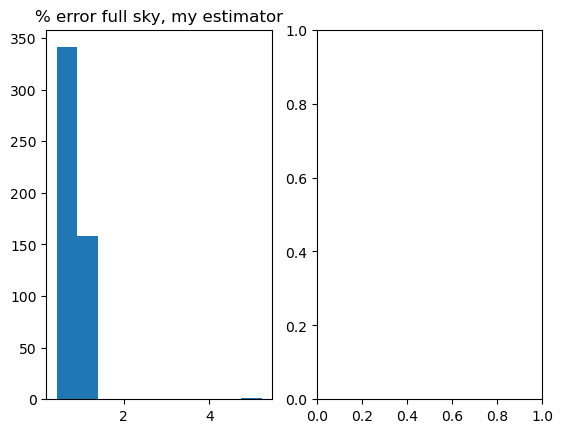

Median of full sky percent error EB estimator: -0.49174990242471617
Std dev of full sky percent error EB estimator: 1.7868822352432796


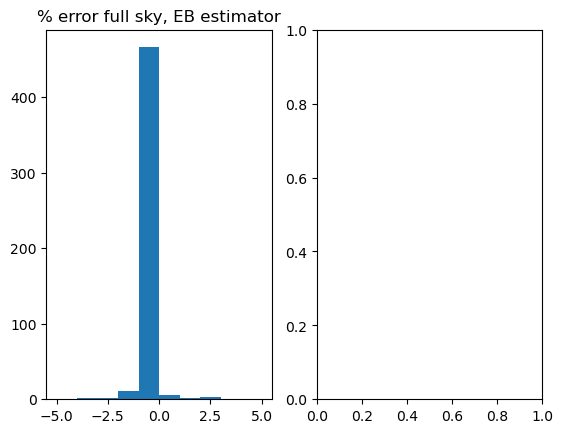

Median of full sky mean TT ratio: 1.0081931913276991
Std dev of full sky mean TT ratio: 0.0011335446963736016


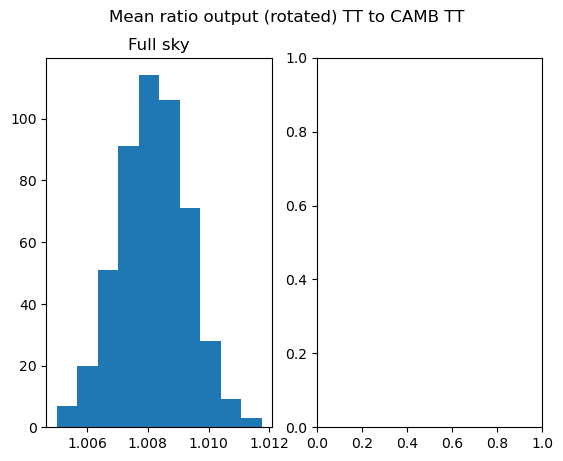

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2)
print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
#print("Median of masked sky percent error: " + str(np.median(percent_diff_mask)))
#print("Std dev of masked sky percent error: " + str(np.std(percent_diff_mask)))
#ax1.hist(percent_diff, bins=np.arange(21)-10)
ax1.hist(percent_diff)
ax1.set_title("% error full sky, my estimator")
#ax2.hist(percent_diff_mask, bins=np.arange(21)-10)
#ax2.hist(percent_diff_mask)
#ax2.set_title("% error mask, my estimator")
#x = np.linspace(-5,5)
#ax2.plot(x,gaussian(x,np.median(percent_diff_mask),np.std(percent_diff_mask)))
plt.show()
plt.close()
fig, (ax1,ax2) = plt.subplots(1,2)
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
#print("Median of masked sky percent error EB estimator: " + str(np.median(percent_diff_eb_mask)))
#print("Std dev of masked sky percent error EB estimator: " + str(np.std(percent_diff_eb_mask)))
#ax1.hist(percent_diff_eb, bins=np.arange(21)-10)
ax1.hist(percent_diff_eb,range=(-5,5))
ax1.set_title("% error full sky, EB estimator")
#ax2.hist(percent_diff_eb_mask, bins=np.arange(21)-10)
#ax2.hist(percent_diff_eb_mask,range=(-5,5))
#ax2.set_title("% error mask, EB estimator")
plt.show()
plt.close()
fig, (ax1,ax2) = plt.subplots(1,2)
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
#print("Median of masked sky mean TT ratio: " + str(np.median(tt_bias_outputs_mask)))
#print("Std dev of masked sky mean TT ratio: " + str(np.std(tt_bias_outputs_mask)))
fig.suptitle("Mean ratio output (rotated) TT to CAMB TT")
ax1.hist(tt_bias_outputs)
ax1.set_title("Full sky")
#ax2.hist(tt_bias_outputs_mask)
#ax2.set_title("Masked sky")
plt.show()
plt.close()

In [8]:
output_spectra = np.array(output_spectra)

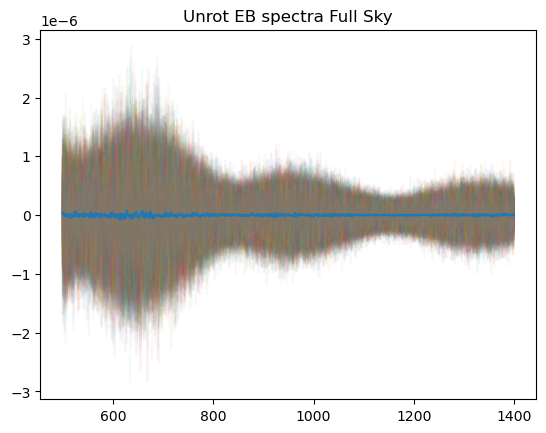

In [9]:
# Plotting all of the EB spectra
mean_EB = np.mean(output_spectra[:,10],axis=0)
#mean_EB_mask = np.mean(output_spectra_mask[:,10],axis=0)

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][10],alpha=0.05)
plt.title("Unrot EB spectra Full Sky")
plt.plot(ell_hp,mean_EB)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

#for i in range(len(output_spectra_mask)):
#    plt.plot(ell_hp,output_spectra_mask[i][10],alpha=0.05)
#plt.title("Unrot EB spectra Masked Sky")
#plt.plot(ell_hp,mean_EB_mask)
#plt.ylim([-0.0005, 0.0005])
#plt.show()
#plt.close()

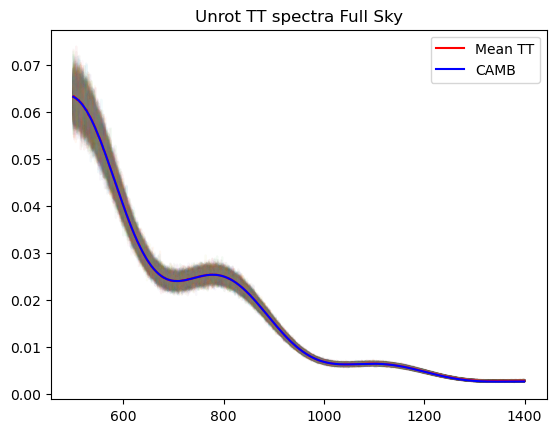

In [10]:
# Plotting all of the TT spectra
mean_TT = np.mean(output_spectra[:,6],axis=0)
#mean_TT_mask = np.mean(output_spectra_mask[:,6],axis=0)

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][6],alpha=0.05)
plt.title("Unrot TT spectra Full Sky")
plt.plot(ell_hp,mean_TT,'r',label='Mean TT')
plt.plot(ell[500:1400],ClTT[500:1400],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

#for i in range(len(output_spectra_mask)):
#    plt.plot(ell_hp,output_spectra_mask[i][6],alpha=0.05)
#plt.title("Unrot TT spectra Masked Sky")
#plt.plot(ell_hp,mean_TT_mask,'r',label='Mean TT')
#plt.plot(ell[500:1400],ClTT[500:1400],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
#plt.legend()
#plt.show()
#plt.close()

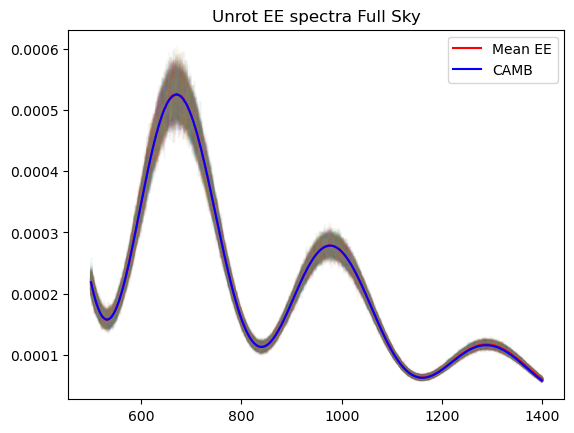

In [11]:
# Plotting all of the EE spectra
mean_EE = np.mean(output_spectra[:,7],axis=0)
#mean_EE_mask = np.mean(output_spectra_mask[:,7],axis=0)

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][7],alpha=0.05)
plt.title("Unrot EE spectra Full Sky")
plt.plot(ell_hp,mean_EE,'r',label='Mean EE')
plt.plot(ell[500:1400],ClEE[500:1400],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

#for i in range(len(output_spectra_mask)):
#    plt.plot(ell_hp,output_spectra_mask[i][7],alpha=0.05)
#plt.title("Unrot EE spectra Masked Sky")
#plt.plot(ell_hp,mean_EE_mask,'r',label='Mean EE')
#plt.plot(ell[500:1400],ClEE[500:1400],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
#plt.legend()
#plt.show()
#plt.close()

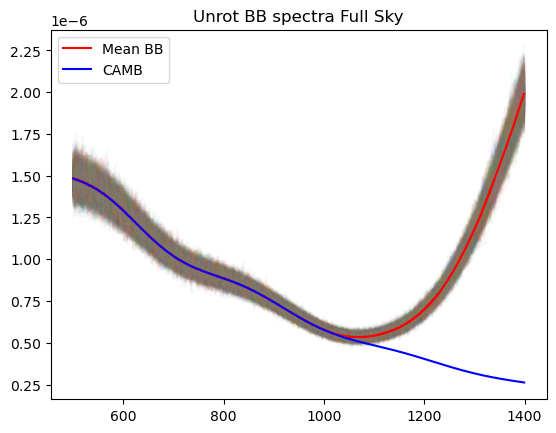

In [12]:
# Plotting all of the BB spectra
mean_BB = np.mean(output_spectra[:,8],axis=0)
#mean_BB_mask = np.mean(output_spectra_mask[:,8],axis=0)

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][8],alpha=0.05)
plt.title("Unrot BB spectra Full Sky")
plt.plot(ell_hp,mean_BB,'r',label='Mean BB')
plt.plot(ell[500:1400],ClBB[500:1400],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

#for i in range(len(output_spectra_mask)):
#    plt.plot(ell_hp,output_spectra_mask[i][8],alpha=0.05)
#plt.title("Unrot BB spectra Masked Sky")
#plt.plot(ell_hp,mean_BB_mask,'r',label='Mean BB')
#plt.plot(ell[500:1400],ClBB[500:1400],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
#plt.legend()
#plt.show()
#plt.close()

In [13]:
# Doing 500 sims of full sky maps with 4 iterations in anafast instead of 3
# to see if 6 was causing the divergence issues in BB
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim

output_angles = []
output_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []

rot_degs = np.random.normal(0, 5, size=(500))
#print("Input angles are: " + str(rot_degs))
for rot_deg in tqdm(rot_degs):
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    CMB_Q = unrot_sim_maps[1]
    CMB_U = unrot_sim_maps[2]
    rot_Q_map =  np.cos(np.deg2rad(2*rot_deg))*CMB_Q + np.sin(np.deg2rad(2*rot_deg))*CMB_U
    rot_U_map = -np.sin(np.deg2rad(2*rot_deg))*CMB_Q + np.cos(np.deg2rad(2*rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0],rot_Q_map,rot_U_map)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps,iter=4)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps,iter=4)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps,iter=4)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps,iter=4)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    tt_bias_outputs.append(np.mean(ClTT_rot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs
#print("Injected rotation angles: ")
#print(rot_degs)
#print("Recovered angles: ")
#print(output_angles_only)
#print("Percent difference: ")
#print(percent_diff)
#print("Recovered null EB angles: ")
#print(output_null_eb_angles_only)
#print("Percent difference: ")
#print(percent_diff_eb)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [2:40:04<00:00, 19.21s/it]


Median of full sky percent error: 0.8649227713402255
Std dev of full sky percent error: 0.12029404645771971


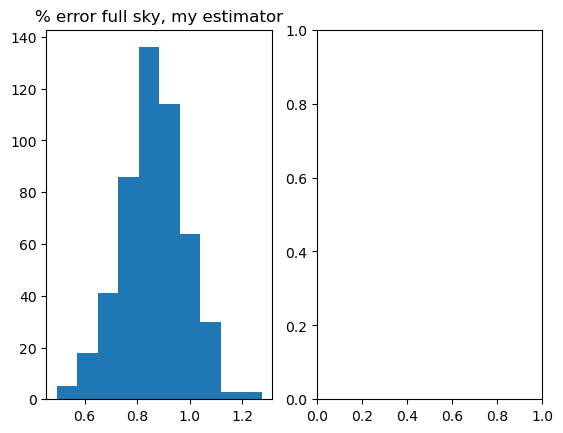

Median of full sky percent error EB estimator: -0.48272398091852675
Std dev of full sky percent error EB estimator: 1.2716493339395178


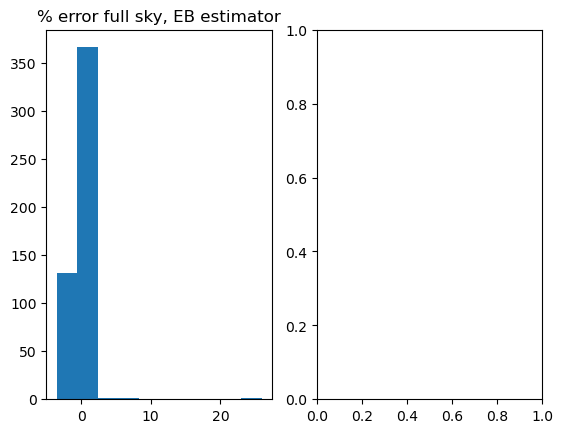

Median of full sky mean TT ratio: 1.00825724079138
Std dev of full sky mean TT ratio: 0.001094046962974242


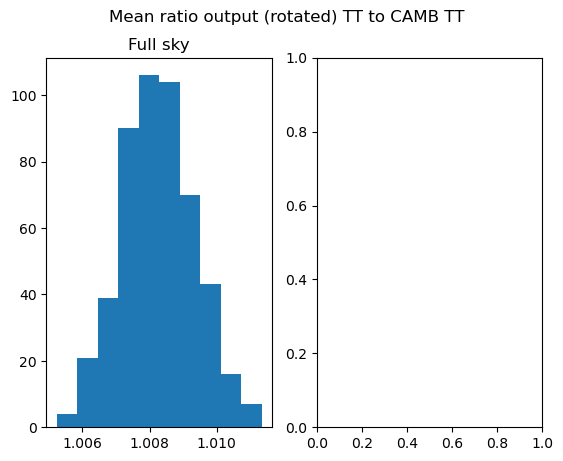

In [21]:
fig, (ax1,ax2) = plt.subplots(1,2)
print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
#print("Median of masked sky percent error: " + str(np.median(percent_diff_mask)))
#print("Std dev of masked sky percent error: " + str(np.std(percent_diff_mask)))
#ax1.hist(percent_diff, bins=np.arange(21)-10)
ax1.hist(percent_diff)
ax1.set_title("% error full sky, my estimator")
#ax2.hist(percent_diff_mask, bins=np.arange(21)-10)
#ax2.hist(percent_diff_mask)
#ax2.set_title("% error mask, my estimator")
#x = np.linspace(-5,5)
#ax2.plot(x,gaussian(x,np.median(percent_diff_mask),np.std(percent_diff_mask)))
plt.show()
plt.close()
fig, (ax1,ax2) = plt.subplots(1,2)
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
#print("Median of masked sky percent error EB estimator: " + str(np.median(percent_diff_eb_mask)))
#print("Std dev of masked sky percent error EB estimator: " + str(np.std(percent_diff_eb_mask)))
#ax1.hist(percent_diff_eb, bins=np.arange(21)-10)
ax1.hist(percent_diff_eb)
ax1.set_title("% error full sky, EB estimator")
#ax2.hist(percent_diff_eb_mask, bins=np.arange(21)-10)
#ax2.hist(percent_diff_eb_mask,range=(-5,5))
#ax2.set_title("% error mask, EB estimator")
plt.show()
plt.close()
fig, (ax1,ax2) = plt.subplots(1,2)
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
#print("Median of masked sky mean TT ratio: " + str(np.median(tt_bias_outputs_mask)))
#print("Std dev of masked sky mean TT ratio: " + str(np.std(tt_bias_outputs_mask)))
fig.suptitle("Mean ratio output (rotated) TT to CAMB TT")
ax1.hist(tt_bias_outputs)
ax1.set_title("Full sky")
#ax2.hist(tt_bias_outputs_mask)
#ax2.set_title("Masked sky")
plt.show()
plt.close()

In [15]:
output_spectra = np.array(output_spectra)

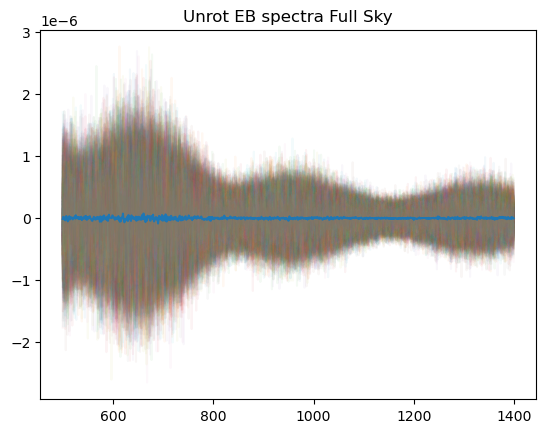

In [16]:
# Plotting all of the EB spectra
mean_EB = np.mean(output_spectra[:,10],axis=0)
#mean_EB_mask = np.mean(output_spectra_mask[:,10],axis=0)

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][10],alpha=0.05)
plt.title("Unrot EB spectra Full Sky")
plt.plot(ell_hp,mean_EB)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

#for i in range(len(output_spectra_mask)):
#    plt.plot(ell_hp,output_spectra_mask[i][10],alpha=0.05)
#plt.title("Unrot EB spectra Masked Sky")
#plt.plot(ell_hp,mean_EB_mask)
#plt.ylim([-0.0005, 0.0005])
#plt.show()
#plt.close()

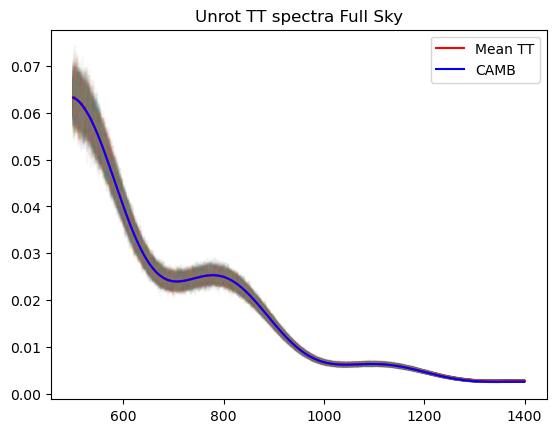

In [17]:
# Plotting all of the TT spectra
mean_TT = np.mean(output_spectra[:,6],axis=0)
#mean_TT_mask = np.mean(output_spectra_mask[:,6],axis=0)

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][6],alpha=0.05)
plt.title("Unrot TT spectra Full Sky")
plt.plot(ell_hp,mean_TT,'r',label='Mean TT')
plt.plot(ell[500:1400],ClTT[500:1400],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

#for i in range(len(output_spectra_mask)):
#    plt.plot(ell_hp,output_spectra_mask[i][6],alpha=0.05)
#plt.title("Unrot TT spectra Masked Sky")
#plt.plot(ell_hp,mean_TT_mask,'r',label='Mean TT')
#plt.plot(ell[500:1400],ClTT[500:1400],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
#plt.legend()
#plt.show()
#plt.close()

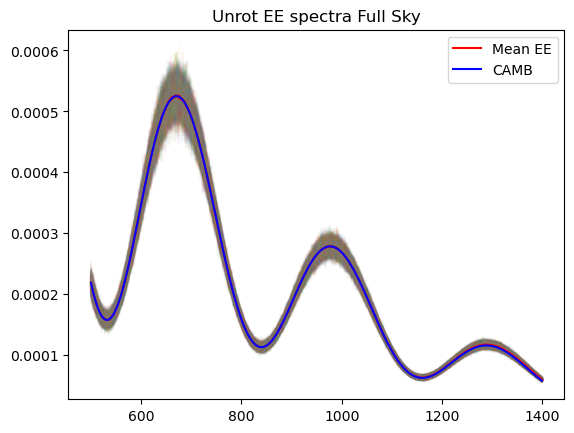

In [18]:
# Plotting all of the EE spectra
mean_EE = np.mean(output_spectra[:,7],axis=0)
#mean_EE_mask = np.mean(output_spectra_mask[:,7],axis=0)

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][7],alpha=0.05)
plt.title("Unrot EE spectra Full Sky")
plt.plot(ell_hp,mean_EE,'r',label='Mean EE')
plt.plot(ell[500:1400],ClEE[500:1400],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

#for i in range(len(output_spectra_mask)):
#    plt.plot(ell_hp,output_spectra_mask[i][7],alpha=0.05)
#plt.title("Unrot EE spectra Masked Sky")
#plt.plot(ell_hp,mean_EE_mask,'r',label='Mean EE')
#plt.plot(ell[500:1400],ClEE[500:1400],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
#plt.legend()
#plt.show()
#plt.close()

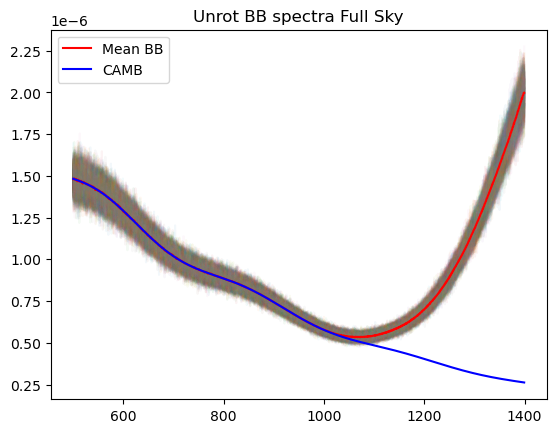

In [19]:
# Plotting all of the BB spectra
mean_BB = np.mean(output_spectra[:,8],axis=0)
#mean_BB_mask = np.mean(output_spectra_mask[:,8],axis=0)

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][8],alpha=0.05)
plt.title("Unrot BB spectra Full Sky")
plt.plot(ell_hp,mean_BB,'r',label='Mean BB')
plt.plot(ell[500:1400],ClBB[500:1400],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

#for i in range(len(output_spectra_mask)):
#    plt.plot(ell_hp,output_spectra_mask[i][8],alpha=0.05)
#plt.title("Unrot BB spectra Masked Sky")
#plt.plot(ell_hp,mean_BB_mask,'r',label='Mean BB')
#plt.plot(ell[500:1400],ClBB[500:1400],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
#plt.legend()
#plt.show()
#plt.close()

In [20]:
help(hp.anafast)

Help on function anafast in module healpy.sphtfunc:

anafast(map1, map2=None, nspec=None, lmax=None, mmax=None, iter=3, alm=False, pol=True, use_weights=False, datapath=None, gal_cut=0, use_pixel_weights=False)
    Computes the power spectrum of a Healpix map, or the cross-spectrum
    between two maps if *map2* is given.
    No removal of monopole or dipole is performed. The input maps must be
    in ring-ordering.
    Spherical harmonics transforms in HEALPix are always on the full sky,
    if the map is masked, those pixels are set to 0. It is recommended to
    remove monopole from the map before running `anafast` to reduce
    boundary effects.
    
    For recommendations about how to set `lmax`, `iter`, and weights, see the
    `Anafast documentation <https://healpix.sourceforge.io/html/fac_anafast.htm>`_
    
    Parameters
    ----------
    map1 : float, array-like shape (Npix,) or (3, Npix)
      Either an array representing a map, or a sequence of 3 arrays
      representin

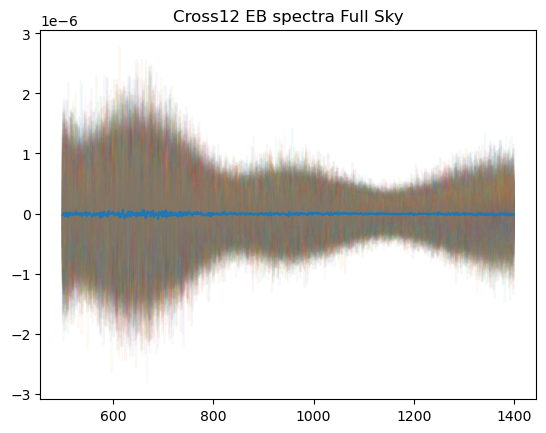

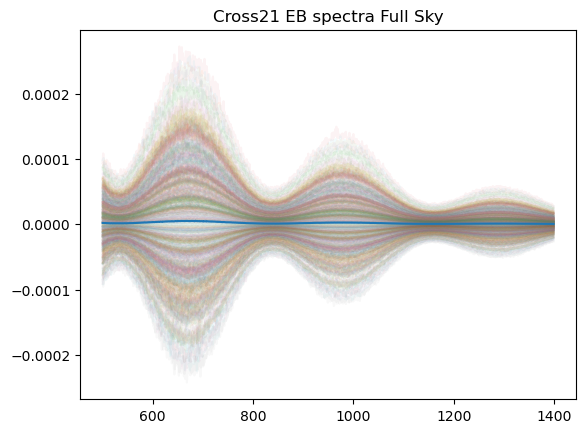

In [22]:
# Plotting all of the EB spectra for the cross spectra used in our estimator
mean_EB_cross12 = np.mean(output_spectra[:,16],axis=0)
mean_EB_cross21 = np.mean(output_spectra[:,22],axis=0)

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i,16],alpha=0.05)
plt.title("Cross12 EB spectra Full Sky")
plt.plot(ell_hp,mean_EB_cross12)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i,22],alpha=0.05)
plt.title("Cross21 EB spectra Full Sky")
plt.plot(ell_hp,mean_EB_cross21)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

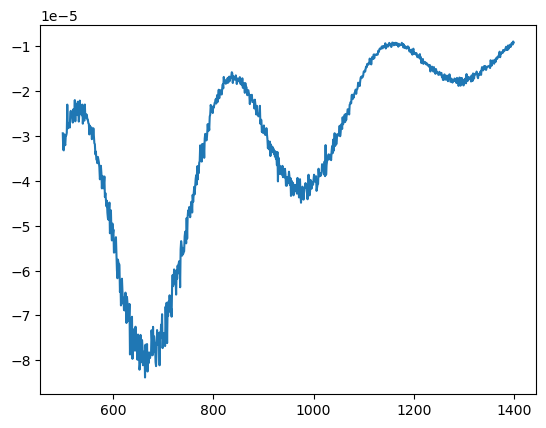

In [31]:
plt.plot(ell_hp,output_spectra[3,22])

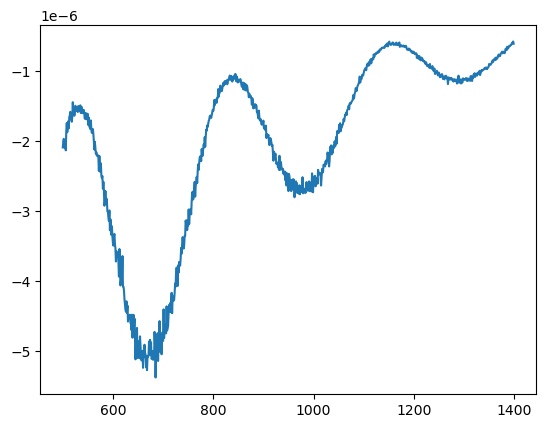

In [32]:
mean_estimator = mean_EB_cross12 - mean_EB_cross21
plt.plot(ell_hp,mean_estimator)

In [33]:
# Testing to see if the average spectra return the same overall bias
mean_EE_rot = np.mean(output_spectra[:,1],axis=0)
mean_BB_unrot = np.mean(output_spectra[:,8],axis=0)
mean_EE_unrot = np.mean(output_spectra[:,7],axis=0)
mean_BB_rot = np.mean(output_spectra[:,2],axis=0)
mean_EE_cross12 = np.mean(output_spectra[:,13],axis=0)
mean_BB_cross12 = np.mean(output_spectra[:,14],axis=0)
mean_EB_rot = np.mean(output_spectra[:,4],axis=0)
mean_EB_unrot = np.mean(output_spectra[:,10],axis=0)

# mean_estimator calculated in cell above

mean_covariance = ((mean_EE_rot*mean_BB_unrot+mean_EB_cross12**2) \
                  + (mean_EE_unrot*mean_BB_rot+mean_EB_cross21**2) \
                  - 2*(mean_EE_cross12*mean_BB_cross12+mean_EB_rot*mean_EB_unrot))
    
fit_values = sample_likelihood_and_fit(mean_estimator,mean_covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
null_eb_fit_values = sample_null_eb_likelihood_and_fit(mean_EB_rot,mean_EE_rot,mean_BB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
print(fit_values)
print(null_eb_fit_values)

(-0.27969054661506576, 0.16332232533593374)
(-0.2627798807005639, 0.1764445920132283)


In [35]:
np.mean(rot_degs)

-0.28156886236176226

So the average spectra return the average rotation angle, as expected.